In [1]:
from os import getcwd
from os.path import abspath, join

from copy import deepcopy
from joblib import parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.data.load_dataset import generate_frequency_detection
from src.models.estimator import RFClassifier, relu
from src.models.weights import sensilla_weights

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

In [33]:
# load data
num_samples, sampling_rate, duration, freq, snr, seed = 7000, 2000, 0.1, 50, 0.8, 5
X, y = generate_frequency_detection(num_samples, sampling_rate, freq, duration, snr, seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

# params
h = 20
bias = 0
nonlinearity = relu
scale = 1
center = None
clf = LinearSVC(tol=1e-4, max_iter=1000)
n_jobs=5
cv = 3

#### Cross-val parameters
- Frequency: 10Hz to 200 Hz in increments of 10 Hz
- decay_coef: 10ms to 100ms in increments of 10 ms

In [58]:
# estimator params
decay_coef = np.arange(0.01, duration + 0.01, 0.01)
params = []
for lowcut in range(10, 200, 10):
    for highcut in range(lowcut + 10, 210, 10):
        for d in decay_coef:
            params.append([lowcut, highcut, round(d, 2)])
params = np.array(params)

In [59]:
# cross-validate
accuracy = np.zeros((len(params), cv))
for i, [lowcut, highcut, gamma] in enumerate(tqdm(params)):
    kwargs = {'sampling_rate':sampling_rate, 'duration':duration, 'lowcut':lowcut, 'highcut':highcut, 
              'decay_coef':gamma, 'scale': scale}
    sensilla_clf = RFClassifier(h, sensilla_weights, bias, nonlinearity, deepcopy(clf), kwargs)
    scores = cross_val_score(sensilla_clf, X_train, y_train, cv=cv, n_jobs=n_jobs, verbose=0)
    accuracy[i] = scores
    
    # save results iteratively
    param_study = {'lowcut': params[:, 0], 'highcut': params[:, 1],  'gamma': params[:, 2], 'scores': accuracy}
    with open(data_dir + '/models/results/freq_detection/freq_detection_param_study_estimator.pickle', 'wb') as file:
        pickle.dump(param_study, file)

100%|██████████| 1900/1900 [10:03<00:00,  3.15it/s]


In [83]:
with open(data_dir + '/models/results/freq_detection/freq_detection_param_study_estimator.pickle', 'rb') as file:
    study = pickle.load(file)
    
mean = np.mean(study['scores'], axis=1)
# print largest sum
idx = np.argmax(mean)
print(study['lowcut'][idx], study['highcut'][idx], study['gamma'][idx], mean[idx])

10.0 60.0 0.05 1.0


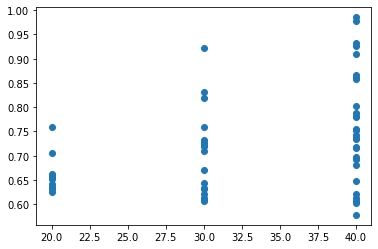

In [90]:
idx = np.logical_and(study['lowcut'] < 50, study['highcut'] < 50)
plt.plot(study['highcut'][idx], mean[idx], 'o')

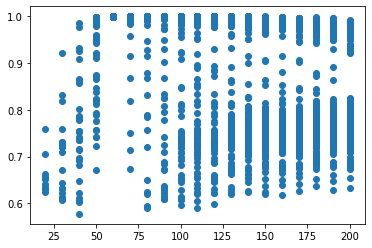

In [87]:
plt.plot(study['highcut'], mean, 'o')